# Excersise No. 1

## Count Amino acid propensity in human proteome

Got to Uniprot and download the latests [here](https://www.uniprot.org/uniprot/?query=*&fil=organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22+AND+reviewed%3Ayes#)

The file containes protein sequences in FASTA format, i.e.
```txt
> (( Identifier line ))
(( Amino acid Sequence, can stretch over multiple lines ))
> (( next identifier line ))
```

Write a function that takes two arguments, 
 * a path to the a fasta database and  
 * an output file name.

The function should do the following:
 * parses the input fasta file 
 * counts the amino acid frequency and 
 * write a csv output file that looks like 

```
aa, count
A, 123123123
C, 3213
D, ...
```

In [7]:
from collections import Counter
import csv

In [8]:
def aa_count(input_file,output_file_suffix):
    output_file_name = f"aa_count_{output_file_suffix}.csv"
    counter = Counter()
    with open(input_file,"r") as file:
        for line in file:
            if line[0] == ">":
                continue
            line = line.rstrip("\n") # removes linebreak character
            counter = counter + Counter(line)
    with open(output_file_name,"w") as output:
        aa_writer = csv.DictWriter(output, fieldnames=["aa","count"], extrasaction="ignore")
        aa_writer.writeheader()
        for key,item in counter.items():
            aa_writer.writerow({"aa":key, "count":item})

In [9]:
aa_count("../../data/animalia/uniprot-filtered-organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22+AND+review--.fasta","human")

## Plot a histogram for human
Use the dictionary created in a) to plot a histogram using your favorit lib

Create a standalone script that will plot the histogram
```bash
$ ./plot_aa_histogram.py "uniprot-filtered-proteome%3AUP000005640+AND+reviewed%3Ayes+AND+organism%3A%22Hom--.fasta"
```

Here you might have to use "../data/uniprot-filtered-organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22+AND+review--.fasta" because my folder structure is different than yours. :)

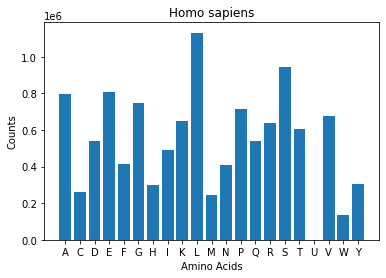

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def create_bar_plot(input_file,output_file_suffix,title):
    output_file_name = f"aa_counts_bar_plot_{output_file_suffix}.png"
    df = pd.read_csv(input_file)
    df = df.sort_values("aa")
    plt.bar(df["aa"], df["count"])
    plt.title(title)
    plt.ylabel("Counts")
    plt.xlabel("Amino Acids")
    plt.savefig(output_file_name)

create_bar_plot("aa_count_human.csv","human","Homo sapiens")

## Rinse and repeat 
Repeat counting and plotting for at leat one organism of the following kingdoms of life:
* Bacteria
* Archea 
* Plantae
* Animalia

Are there difference? 

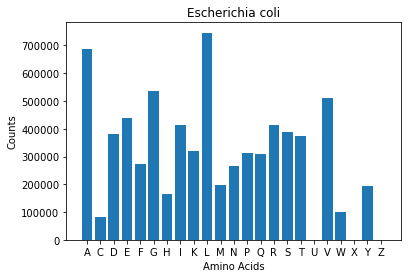

In [11]:
# For bacteria
aa_count("../../data/bacteria/uniprot-organism%3A%22Escherichia+coli%22+AND+reviewed%3Ayes.fasta","ecoli")
create_bar_plot("aa_count_ecoli.csv","ecoli","Escherichia coli")

In [12]:
# For archea

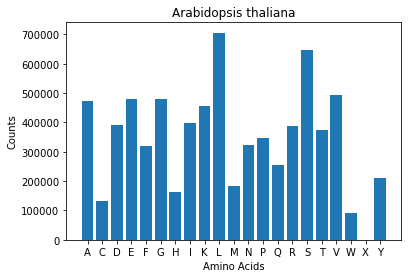

In [13]:
# For plantae
aa_count("../../data/plantae/uniprot-organism%3A%22Arabidopsis+thaliana%22+AND+reviewed%3Ayes.fasta","thaliana")
create_bar_plot("aa_count_thaliana.csv","thaliana","Arabidopsis thaliana")

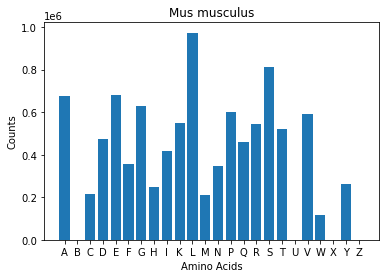

In [14]:
# For (another) animalia (Mus musculus)

aa_count("../../data/animalia/uniprot-organism%3A%22Mus+musculus%22+AND+reviewed%3Ayes.fasta","musculus")
create_bar_plot("aa_count_musculus.csv","musculus","Mus musculus")

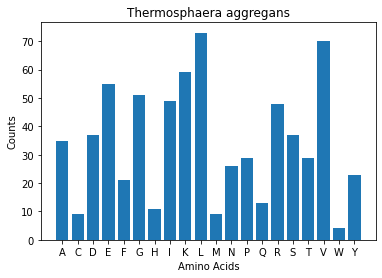

In [15]:
# For archea (Thermosphaera aggregans)

aa_count("../../data/archea/uniprot-organism%3A%22Thermosphaera+aggregans%22+AND+reviewed%3Ayes.fasta","aggregans")
create_bar_plot("aa_count_aggregans.csv","aggregans","Thermosphaera aggregans")

There were differences between the counts, animals have higher counts due to the bigger genome. However, I suspect that for the archea organism, maybe not all proteins were discovered yet (only 2 entries).

# Find special proteins

Find the most extreme proteins
* lowest / highest pI
* longest / shortest proteins
* highest density [mass / amino acid counts]
* most hydrophobic, hydrophic 


Here is my attempt at the special proteins exercise. I am sure there are better ways to do this. However, it was already late and I am happy that I got this. :)

In [16]:
from Bio import SeqIO
from Bio import SeqUtils

list_id=[]
list_seq=[]

for record in SeqIO.parse("../../data/animalia/uniprot-filtered-organism%3A%22Homo+sapiens+%28Human%29+%5B9606%5D%22+AND+review--.fasta","fasta"):
    list_id.append(record.id)
    list_seq.append(record.seq)

In [17]:
df = pd.DataFrame(list(zip(list_id,list_seq)),columns=["Info","Sequence"])


In [18]:
df["Length"] = df.apply(lambda row: len(row["Sequence"]), axis=1)

In [19]:
# Longest Protein
df[df["Length"]==max(df["Length"])]

,Info,Sequence,Length
18115,sp|Q8WZ42|TITIN_HUMAN,"(M, T, T, Q, A, P, T, F, T, Q, P, L, Q, S, V, ...",34350


In [20]:
# Shortest Protein
df[df["Length"]==min(df["Length"])]

,Info,Sequence,Length
19659,sp|P0DPR3|TRDD1_HUMAN,"(E, I)",2


In [21]:
df["Mass"] = df.apply(lambda row: SeqUtils.molecular_weight(row["Sequence"],seq_type="protein"),axis=1)
    

In [22]:
df["Density"] = df.apply(lambda row: row["Mass"]/row["Length"],axis=1)

In [23]:
# Protein with the highest density

df[df["Density"]==max(df["Density"])]

,Info,Sequence,Length,Mass,Density
616,sp|P62945|RL41_HUMAN,"(M, R, A, K, W, R, K, K, R, M, R, R, L, K, R, ...",25,3456.3183,138.252732


In [24]:
def calculate_percentage_hydrophobic(row):
    # http://www.imgt.org/IMGTeducation/Aide-memoire/_UK/aminoacids/IMGTclasses.html
    list_hydrophobic = ["F","W","I","L","M","V","C","A"]
    list_neutral = ["Y","H","P","T","G","S"]
    list_hydrophilic = ["K","R","E","Q","D","N"]
    counter = Counter(row["Sequence"])
    counter_hydrophobic = 0
    counter_neutral = 0
    counter_hydrophilic = 0
    for i in list_hydrophobic:
        counter_hydrophobic += counter[i]
    for i in list_neutral:
        counter_neutral += counter[i]
    for i in list_hydrophilic:
        counter_hydrophilic += counter[i]
    return (counter_hydrophobic/(counter_hydrophobic+counter_hydrophilic+counter_neutral))

df["Hydrophobic"] = df.apply(lambda row: calculate_percentage_hydrophobic(row),axis=1)



In [25]:
# Protein with the highest percentage hydrophobic

df[df["Hydrophobic"]==max(df["Hydrophobic"])]

,Info,Sequence,Length,Mass,Density,Hydrophobic
19116,sp|Q9NRI7|PPY2_HUMAN,"(M, A, A, A, C, R, C, L, S, L, L, L, L, S, T, ...",21,2178.7876,103.75179,0.809524
